In [ ]:
from pipeline import Pipeline
from lang_pair import LangPair

from models.encoder import Encoder
from models.decoder import Decoder

from coach import Coach
import torch.optim as optim
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
vi_vi_vocab, vi_en_vocab = Pipeline.load("vi_vi_train_10_chars_10k_vocab").data, Pipeline.load("vi_en_train_10_chars_10k_vocab").data
vi_vi_idxs, vi_en_idxs = Pipeline.load("vi_idx_10chars_filter").data

In [8]:
vi_en_pair = LangPair(vi_vi_idxs, vi_vi_vocab.eos_idx, vi_en_idxs, vi_en_vocab.eos_idx, device = device)

In [35]:
batch_size = 32
learning_rate = .0001

In [36]:
enc_params = {
    "input_vocab_size": vi_vi_vocab.size,
    "hidden_size": 300,
    "n_layers": 2,
    "dropout": .3
}

In [37]:
dec_params = {
    "target_vocab_size": vi_en_vocab.size,
    "hidden_size": 300,
    "n_layers": 2,
    "dropout": .3,
    "batch_size": batch_size
}

In [38]:
encoder = Encoder(**enc_params).to(device)
decoder = Decoder(**dec_params).to(device)

In [39]:
enc_optimizer = optim.SGD(encoder.parameters(), lr = learning_rate)
dec_optimizer = optim.SGD(decoder.parameters(), lr = learning_rate)
loss_fn = nn.NLLLoss()

In [40]:
coach_params = {
    "lang_pair": vi_en_pair, 
    "encoder": encoder, 
    "enc_optimizer": enc_optimizer, 
    "decoder": decoder, 
    "dec_optimizer": dec_optimizer, 
    "loss_fn": loss_fn
}

coach = Coach(**coach_params)

In [41]:
training_params = {
    "learning_rate": learning_rate,
    "iterations": 10000,
    "print_interval": 1000,
    "batch_size": batch_size
}

In [ ]:
losses = coach.train(**training_params)

Training Iterations:  10%|▉         | 31/312 [00:39<06:11,  1.32s/batch]

Interval (1/31) average loss: 10.5918


Training Iterations:  20%|█▉        | 62/312 [01:16<04:12,  1.01s/batch]

Interval (2/31) average loss: 10.5881


Training Iterations:  30%|██▉       | 93/312 [01:52<04:28,  1.22s/batch]

Interval (3/31) average loss: 10.5877


Training Iterations:  32%|███▏      | 99/312 [01:59<04:13,  1.19s/batch]

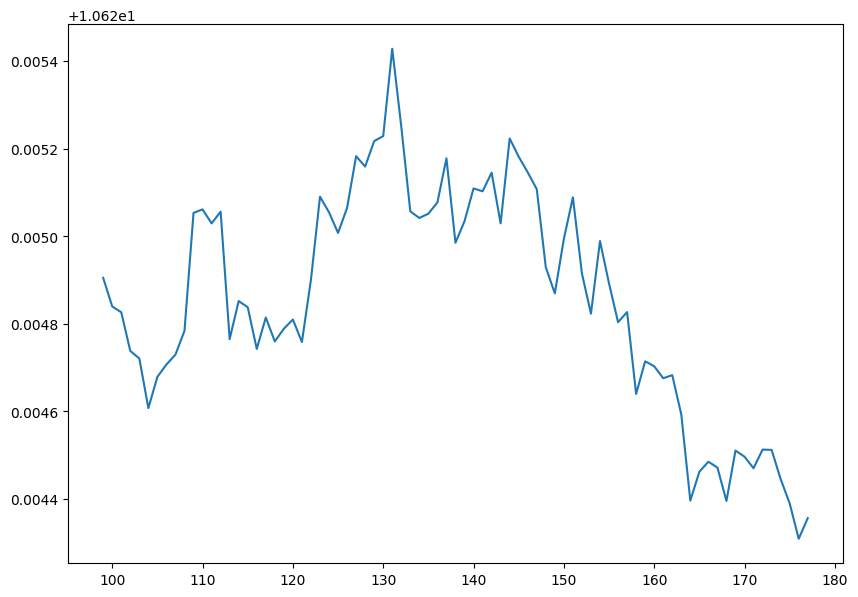

In [30]:
plt.plot(pd.Series(losses).rolling(100).mean())
plt.show()